<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/RF_plan_mensual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
## 1. CARGA DEL DATASET
import pandas as pd
import numpy as np
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)

## 2. ESTANDARIZACIÓN Y TIPOS
df.columns = [c.replace('Real Diario', 'Fecha').replace(' ', '_').replace('(', '').replace(')', '').replace('%', 'Pct').replace('.', '') for c in df.columns]

for col in df.columns:
    if col != 'Fecha':
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

## 3. UNIFICACIÓN DE ESCALAS Y UNIDADES (Lo que ya validamos)
cols_pct = [c for c in df.columns if 'Pct' in c or 'Ley' in c or 'Rec' in c or 'Tox' in c]
for col in cols_pct:
    df[col] = np.where(df[col] > 1.1, df[col] / 100.0, df[col])

# Sincronizar Fino Recuperado con Filtrado (x100)
if df['Cu_Fino_Recuperado_t'].mean() < 50:
    df['Cu_Fino_Recuperado_t'] = df['Cu_Fino_Recuperado_t'] * 100.0

## 4. ELIMINACIÓN DE NULOS Y OUTLIERS FÍSICOS (Sin completar nada)
# Eliminamos cualquier día con datos faltantes (paradas de planta)
df_limpio = df.dropna().copy()

# Filtramos errores de sensor/digitación obvios que detectamos en el describe
df_limpio = df_limpio[
    (df_limpio['Ley_Pct'] <= 0.05) & # No existe ley de alimentación de 103% (1.03)
    (df_limpio['Tonelaje_Stock_Pile_Kt'] < 3000) & # Filtramos el stock pile de 9000
    (df_limpio['Rec_Pct'] > 0.1) # Si la recuperación es casi 0, no hay proceso real
]

print(f"Días con operación completa y válida: {len(df_limpio)}")
print("\n--- Estadísticas Finales para ML ---")
print(df_limpio.describe())

df_limpio.describe()
## conclusion: se observa un -10 en el stock pile lo cual no es correcto

## correccion
# Eliminamos las filas donde el Stock Pile sea negativo antes de cerrar el modelo
df_limpio = df_limpio[df_limpio['Tonelaje_Stock_Pile_Kt'] >= 0]

# Verificamos que el mínimo ahora sea 0 o superior
print(f"Nuevo mínimo de Stock Pile: {df_limpio['Tonelaje_Stock_Pile_Kt'].min()}")
print(df_limpio.describe())
## conclusion: verificado, correcto
df_limpio.head()

,Fecha,Chancado_Kt,Molido_Kt,Ley_Pct,Tox_Pct,Rec_Pct,Rec_Modelo_Pct,Cu_Fino_Recuperado_t,Cu_Fino_Filtrado_t,Grado_Conc_Filtrado_Pct,PctFinos,Stock_Pile_Pct,Tonelaje_Stock_Pile_Kt,Humedad_de_Concentrado_Pct,Disponibilidad_Chancado_Pct,Uso_de_Disponibilidad_Chancado_Pct,Disponibilidad_Molienda_Pct,Uso_de_Disponibilidad_Molienda_Pct
count,2195,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.000000,2195.00000,2195.000000,2195.000000,2195.000000
mean,2022-11-10 10:59:58.359908864,143.141627,142.930236,0.007380,0.094455,0.870490,0.871890,926.780172,924.068212,0.325866,0.314464,0.722627,785.952542,0.096653,0.92408,0.829171,0.963766,0.991100
min,2019-07-01 00:00:00,0.000000,2.226490,0.003169,0.030800,0.551700,0.764541,11.695000,0.000000,0.000000,0.172000,0.000000,0.000000,0.000000,0.00000,0.000000,0.030000,0.000000
25%,2021-03-22 12:00:00,134.498913,139.688838,0.005824,0.074156,0.848850,0.854662,693.608478,697.656265,0.296301,0.296000,0.601500,642.026973,0.091000,0.96000,0.810000,1.000000,1.000000
50%,2022-12-15 00:00:00,153.568371,149.354515,0.007309,0.091300,0.874440,0.874380,911.477647,912.937707,0.324950,0.314000,0.750000,811.751309,0.096013,1.00000,0.880000,1.000000,1.000000
75%,2024-06-22 12:00:00,165.032191,155.301496,0.008721,0.111902,0.895965,0.890498,1142.950430,1135.000500,0.355019,0.332000,0.889500,957.487445,0.101982,1.00000,0.930000,1.000000,1.000000
max,2025-12-30 00:00:00,186.585592,186.130798,0.015757,0.207935,0.954427,0.959400,2086.004000,2069.331000,0.457520,0.441000,1.000000,1270.683155,0.135147,1.00000,1.000000,1.000000,1.000000
std,NaN,36.167065,22.824467,0.002020,0.027130,0.036817,0.027431,318.082638,319.159867,0.041838,0.029857,0.207506,244.151767,0.009421,0.19401,0.182810,0.117438,0.059003


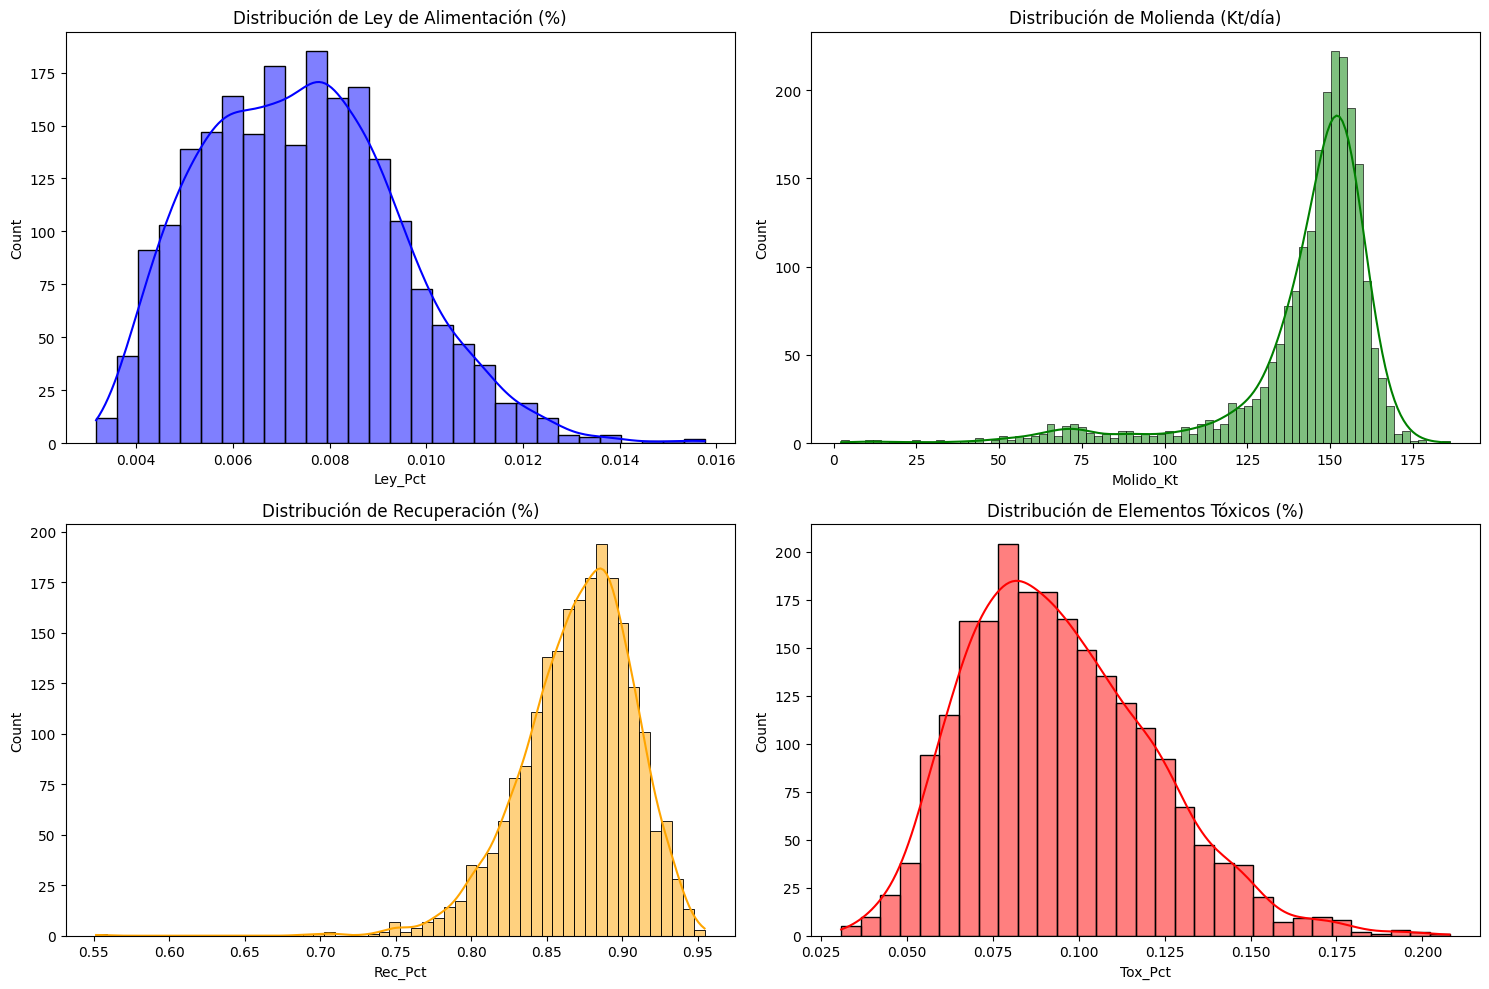

In [11]:
## EDA de las variables

import matplotlib.pyplot as plt
import seaborn as sns

# Configuramos el estilo
plt.style.use('seaborn-v0_8-muted')
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de la Ley
sns.histplot(df_limpio['Ley_Pct'], kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Distribución de Ley de Alimentación (%)')

# Distribución del Molido
sns.histplot(df_limpio['Molido_Kt'], kde=True, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Distribución de Molienda (Kt/día)')

# Distribución de la Recuperación
sns.histplot(df_limpio['Rec_Pct'], kde=True, ax=axs[1, 0], color='orange')
axs[1, 0].set_title('Distribución de Recuperación (%)')

# Distribución de Tóxicos
sns.histplot(df_limpio['Tox_Pct'], kde=True, ax=axs[1, 1], color='red')
axs[1, 1].set_title('Distribución de Elementos Tóxicos (%)')

plt.tight_layout()
plt.show()

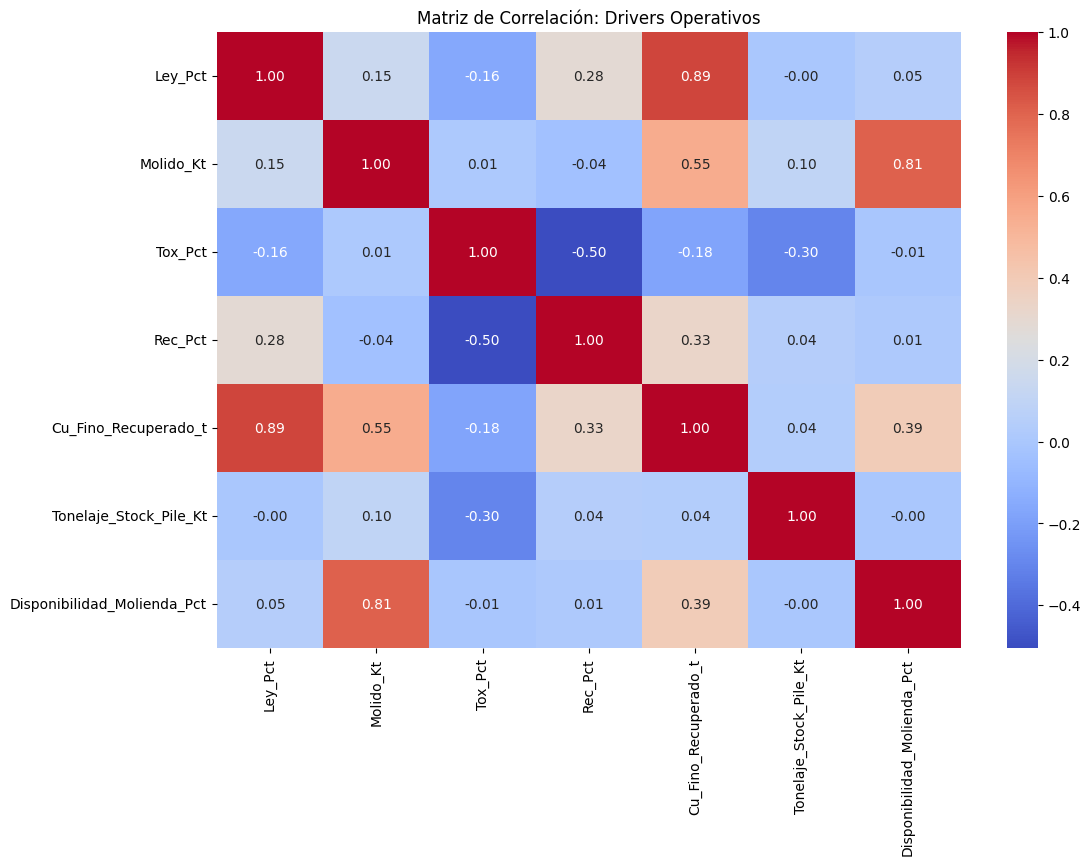

In [12]:
## Matriz de correlación heatmap
plt.figure(figsize=(12, 8))
# Seleccionamos las variables más importantes para no saturar el gráfico
cols_eda = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Rec_Pct', 'Cu_Fino_Recuperado_t', 'Tonelaje_Stock_Pile_Kt', 'Disponibilidad_Molienda_Pct']
correlation_matrix = df_limpio[cols_eda].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación: Drivers Operativos')
plt.show()

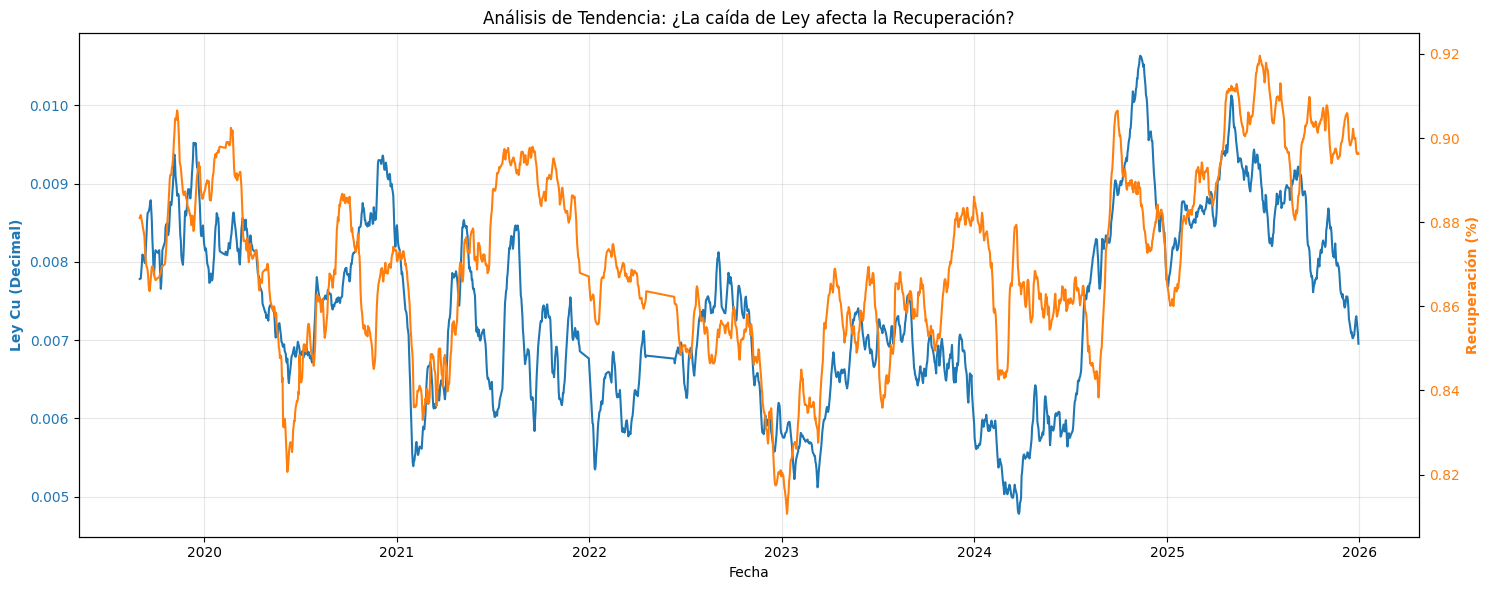

In [14]:
## analisis de tendencia temporal
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 6))

# Primer eje: Ley de Cu (Azul)
color_ley = 'tab:blue'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ley Cu (Decimal)', color=color_ley, fontweight='bold')
ax1.plot(df_limpio['Fecha'], df_limpio['Ley_Pct'].rolling(window=30).mean(), color=color_ley, label='Ley Cu (30d)')
ax1.tick_params(axis='y', labelcolor=color_ley)

# Segundo eje: Recuperación (Naranja)
ax2 = ax1.twinx() # Crea el eje Y secundario
color_rec = 'tab:orange'
ax2.set_ylabel('Recuperación (%)', color=color_rec, fontweight='bold')
ax2.plot(df_limpio['Fecha'], df_limpio['Rec_Pct'].rolling(window=30).mean(), color=color_rec, label='Recuperación (30d)')
ax2.tick_params(axis='y', labelcolor=color_rec)

plt.title('Análisis de Tendencia: ¿La caída de Ley afecta la Recuperación?')
ax1.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

In [16]:
## " dias negros de produccion"
from sklearn.ensemble import RandomForestRegressor

# 1. Entrenamos el modelo con las variables que ya validamos como drivers
features_final = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Disponibilidad_Molienda_Pct']
X = df_limpio[features_final]
y = df_limpio['Cu_Fino_Recuperado_t']

modelo_final = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_final.fit(X, y)

# 2. Generamos la predicción y calculamos la ineficiencia (Residuo)
df_limpio['Produccion_IA'] = modelo_final.predict(X)
df_limpio['Perdida_t'] = df_limpio['Cu_Fino_Recuperado_t'] - df_limpio['Produccion_IA']

# 3. Extraemos el Top 10 de días con mayor pérdida operativa
dias_negros = df_limpio.sort_values(by='Perdida_t').head(10)

print("--- REPORTE DE INEFICIENCIAS: TOP 10 DÍAS NEGROS ---")
dias_negros[['Fecha', 'Ley_Pct', 'Tox_Pct', 'Rec_Pct', 'Perdida_t']]


--- REPORTE DE INEFICIENCIAS: TOP 10 DÍAS NEGROS ---


,Fecha,Ley_Pct,Tox_Pct,Rec_Pct,Perdida_t
673,2021-05-05,0.010900,0.061000,0.749600,-91.839197
750,2021-07-21,0.010255,0.097250,0.904830,-91.388773
333,2020-05-30,0.006893,0.087050,0.551700,-78.795185
598,2021-02-19,0.010296,0.078910,0.751480,-73.680586
751,2021-07-22,0.012957,0.063720,0.882760,-70.435550
2234,2025-08-13,0.010718,0.059603,0.825971,-68.994180
644,2021-04-06,0.008921,0.071960,0.755250,-66.192271
672,2021-05-04,0.010300,0.068100,0.773100,-64.727669
1958,2024-11-10,0.011867,0.129808,0.887987,-62.552374
480,2020-10-24,0.008430,0.065490,0.745120,-58.272224


In [17]:
## anomalias operativas
# Definición de umbrales para "Días de Alta Potencialidad"
umbral_molienda = 150
umbral_ley = 0.01

# Filtramos los días donde deberíamos haber tenido producción récord
dias_potenciales = df_limpio[
    (df_limpio['Molido_Kt'] > umbral_molienda) &
    (df_limpio['Ley_Pct'] > umbral_ley)
]

# De esos días, buscamos los que tuvieron recuperación por debajo de la media (87%)
dias_atipicos = dias_potenciales[dias_potenciales['Rec_Pct'] < 0.87].copy()

# Ordenamos por la mayor pérdida de recuperación para ver los casos más graves
dias_atipicos = dias_atipicos.sort_values(by='Rec_Pct')

print(f"Se detectaron {len(dias_atipicos)} días con condiciones ideales pero baja eficiencia.")
dias_atipicos[['Fecha', 'Molido_Kt', 'Ley_Pct', 'Tox_Pct', 'Rec_Pct', 'Perdida_t']].head(10)

Se detectaron 36 días con condiciones ideales pero baja eficiencia.


,Fecha,Molido_Kt,Ley_Pct,Tox_Pct,Rec_Pct,Perdida_t
673,2021-05-05,160.770000,0.010900,0.061000,0.749600,-91.839197
598,2021-02-19,157.157210,0.010296,0.078910,0.751480,-73.680586
672,2021-05-04,157.140000,0.010300,0.068100,0.773100,-64.727669
341,2020-06-07,156.398450,0.010084,0.119030,0.776240,-53.597812
1851,2024-07-26,168.330299,0.011104,0.198010,0.802826,-20.451404
645,2021-04-07,158.347269,0.010426,0.072090,0.804170,-42.721035
701,2021-06-02,152.655891,0.011100,0.055980,0.808840,-30.016696
633,2021-03-26,154.081422,0.010060,0.070870,0.830634,-27.832604
476,2020-10-20,152.647891,0.011152,0.083980,0.837770,-23.038423
1733,2024-03-30,151.325343,0.010696,0.123825,0.838021,-3.066632


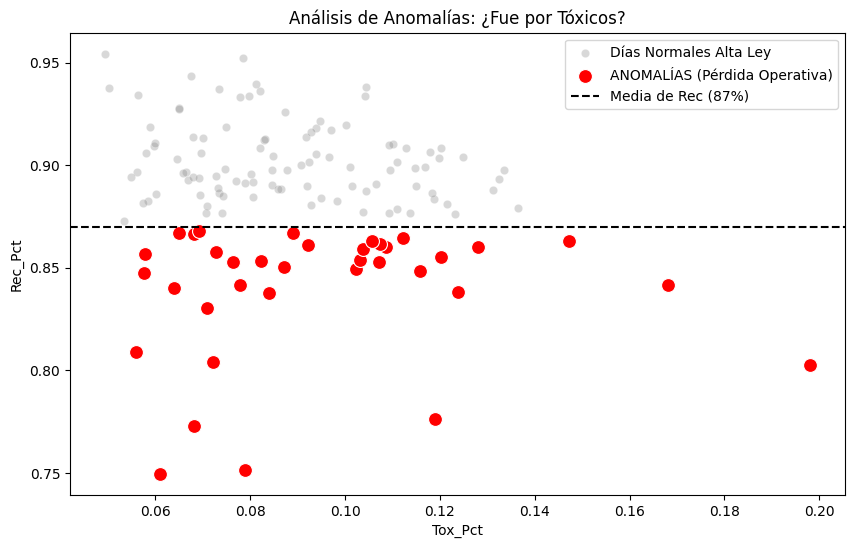

In [18]:
## influencia con el porcentaje de toxicos
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Graficamos todos los días potenciales
sns.scatterplot(data=dias_potenciales, x='Tox_Pct', y='Rec_Pct', color='gray', alpha=0.3, label='Días Normales Alta Ley')

# Resaltamos los días atípicos (Anomalías)
sns.scatterplot(data=dias_atipicos, x='Tox_Pct', y='Rec_Pct', color='red', s=100, label='ANOMALÍAS (Pérdida Operativa)')

plt.axhline(0.87, color='black', linestyle='--', label='Media de Rec (87%)')
plt.title('Análisis de Anomalías: ¿Fue por Tóxicos?')
plt.legend()
plt.show()

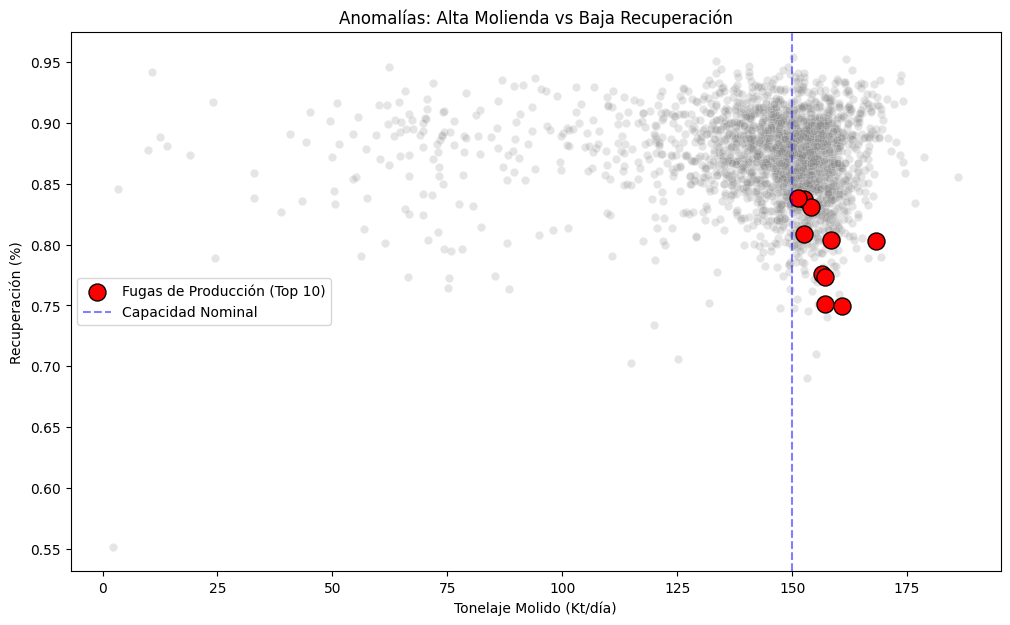

In [19]:
## frontera de eficiencia
import matplotlib.pyplot as plt
import seaborn as sns

# Creamos una columna para marcar los días atípicos en el dataframe original
df_limpio['Es_Atipico'] = df_limpio.index.isin([673, 598, 672, 341, 1851, 645, 701, 633, 476, 1733])

plt.figure(figsize=(12, 7))
# Fondo: Todos los días de operación
sns.scatterplot(data=df_limpio, x='Molido_Kt', y='Rec_Pct', alpha=0.2, color='gray')
# Resaltado: Los 10 días de la lista
sns.scatterplot(data=df_limpio[df_limpio['Es_Atipico']], x='Molido_Kt', y='Rec_Pct', color='red', s=150, edgecolor='black', label='Fugas de Producción (Top 10)')

plt.axvline(150, color='blue', linestyle='--', alpha=0.5, label='Capacidad Nominal')
plt.title('Anomalías: Alta Molienda vs Baja Recuperación')
plt.xlabel('Tonelaje Molido (Kt/día)')
plt.ylabel('Recuperación (%)')
plt.legend()
plt.show()

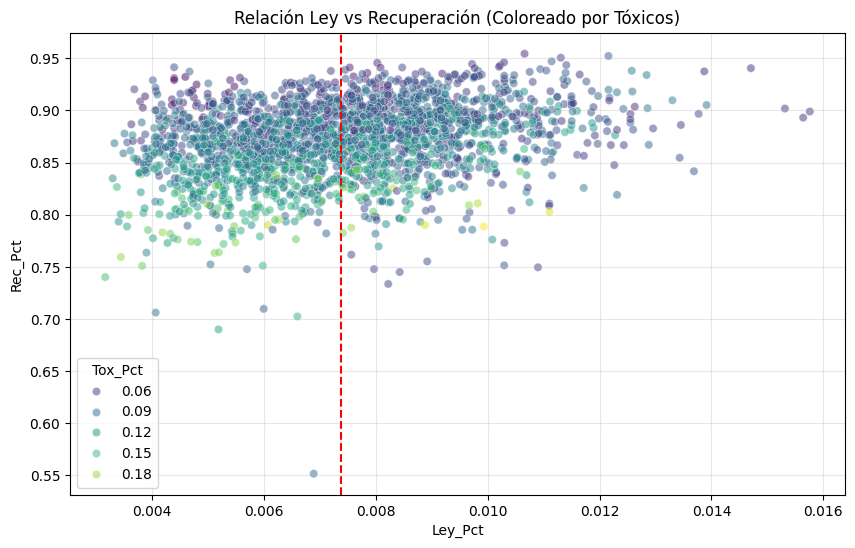

In [15]:
## scatter plots
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_limpio, x='Ley_Pct', y='Rec_Pct', hue='Tox_Pct', palette='viridis', alpha=0.5)
plt.title('Relación Ley vs Recuperación (Coloreado por Tóxicos)')
plt.axvline(df_limpio['Ley_Pct'].mean(), color='red', linestyle='--', label='Ley Media')
plt.grid(True, alpha=0.3)
plt.show()

In [42]:
## implementacion del molode randon forest
# Actualizamos nuestra lista de variables incluyendo Tox_Pct
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

##actualizacion e implementacion de features para el modelo
# 1. Crear una variable de interacción entre Ley y Tóxicos
# (Porque leyes altas con muchos tóxicos se comportan diferente)
df_limpio['Ley_x_Tox'] = df_limpio['Ley_Pct'] * df_limpio['Tox_Pct']

# 2. Variable de 'Estrés de Planta'
# (Marca si estamos operando por encima de la capacidad nominal detectada en el EDA)
df_limpio['Sobre_Capacidad'] = (df_limpio['Molido_Kt'] > 150).astype(int)

# 3. Definir las nuevas variables de entrada actualizadas
features_actualizados = [
    'Ley_Pct',
    'Molido_Kt',
    'Tox_Pct',
    'Ley_x_Tox',
    'Sobre_Capacidad',
    'Disponibilidad_Molienda_Pct'
]

X = df_limpio[features_actualizados]
y = df_limpio['Cu_Fino_Recuperado_t']

#entranamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo actualizado
modelo_v2 = RandomForestRegressor(n_estimators=150, max_depth=15, random_state=42)
modelo_v2.fit(X_train, y_train)

# Evaluación
predicciones = modelo_v2.predict(X_test)
print(f"Nuevo R2: {r2_score(y_test, predicciones):.4f}")
print(f"Nuevo MAE: {mean_absolute_error(y_test, predicciones):.2f} t")


## importancia de variables
import pandas as pd
import matplotlib.pyplot as plt

# 1. Obtener las importancias del modelo actualizado
importancias = modelo_v2.feature_importances_
nombres_features = features_actualizados

# 2. Crear un DataFrame organizado
df_importancia = pd.DataFrame({
    'Variable': nombres_features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=True)

# 3. Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='darkred')
plt.title('Importancia de Variables: Modelo v2 (Enriquecido con EDA)')
plt.xlabel('Peso Relativo en la Predicción')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir etiquetas de porcentaje
for index, value in enumerate(df_importancia['Importancia']):
    plt.text(value, index, f' {value*100:.2f}%')

plt.show()


Nuevo R2: 0.9849
Nuevo MAE: 28.50 t


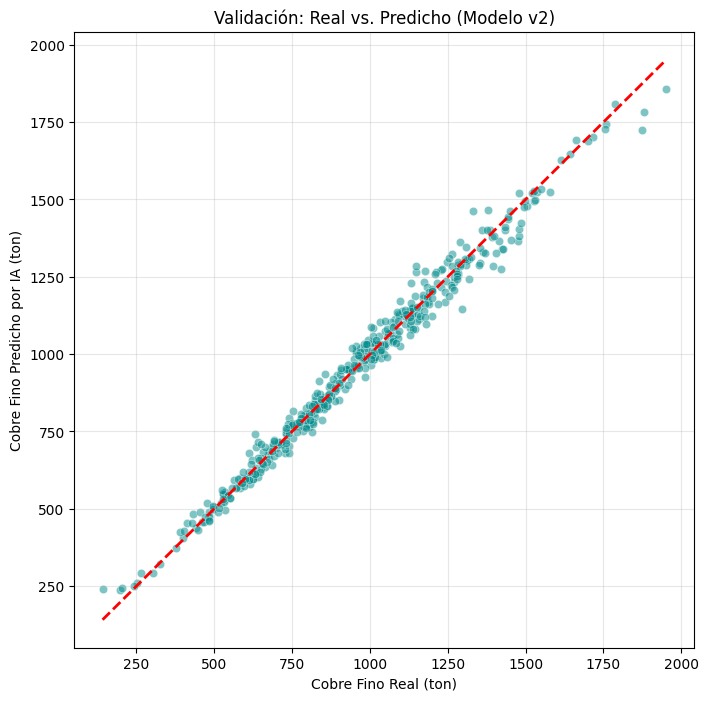

In [26]:
## validacion del modelo
## grafico de dispersion
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=predicciones, alpha=0.5, color='darkcyan')

# Línea de referencia (lo ideal)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Validación: Real vs. Predicho (Modelo v2)')
plt.xlabel('Cobre Fino Real (ton)')
plt.ylabel('Cobre Fino Predicho por IA (ton)')
plt.grid(True, alpha=0.3)
plt.show()

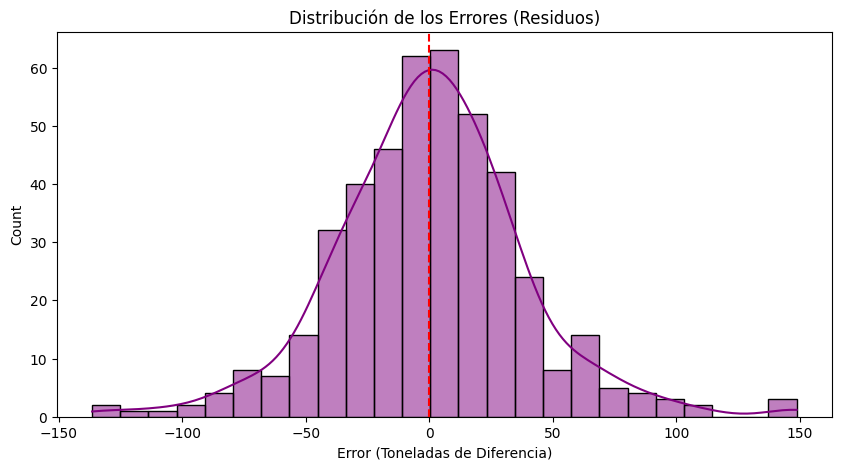

In [27]:
## analisis de residuos
residuos = y_test - predicciones

plt.figure(figsize=(10, 5))
sns.histplot(residuos, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución de los Errores (Residuos)')
plt.xlabel('Error (Toneladas de Diferencia)')
plt.show()

In [28]:
## validacion cruzada
from sklearn.model_selection import cross_val_score

# Evaluamos el modelo 5 veces con diferentes subconjuntos
scores = cross_val_score(modelo_v2, X, y, cv=5, scoring='r2')

print(f"R2 promedio en Cross-Val: {scores.mean():.4f}")
print(f"Desviación estándar de R2: {scores.std():.4f}")

R2 promedio en Cross-Val: 0.9727
Desviación estándar de R2: 0.0144


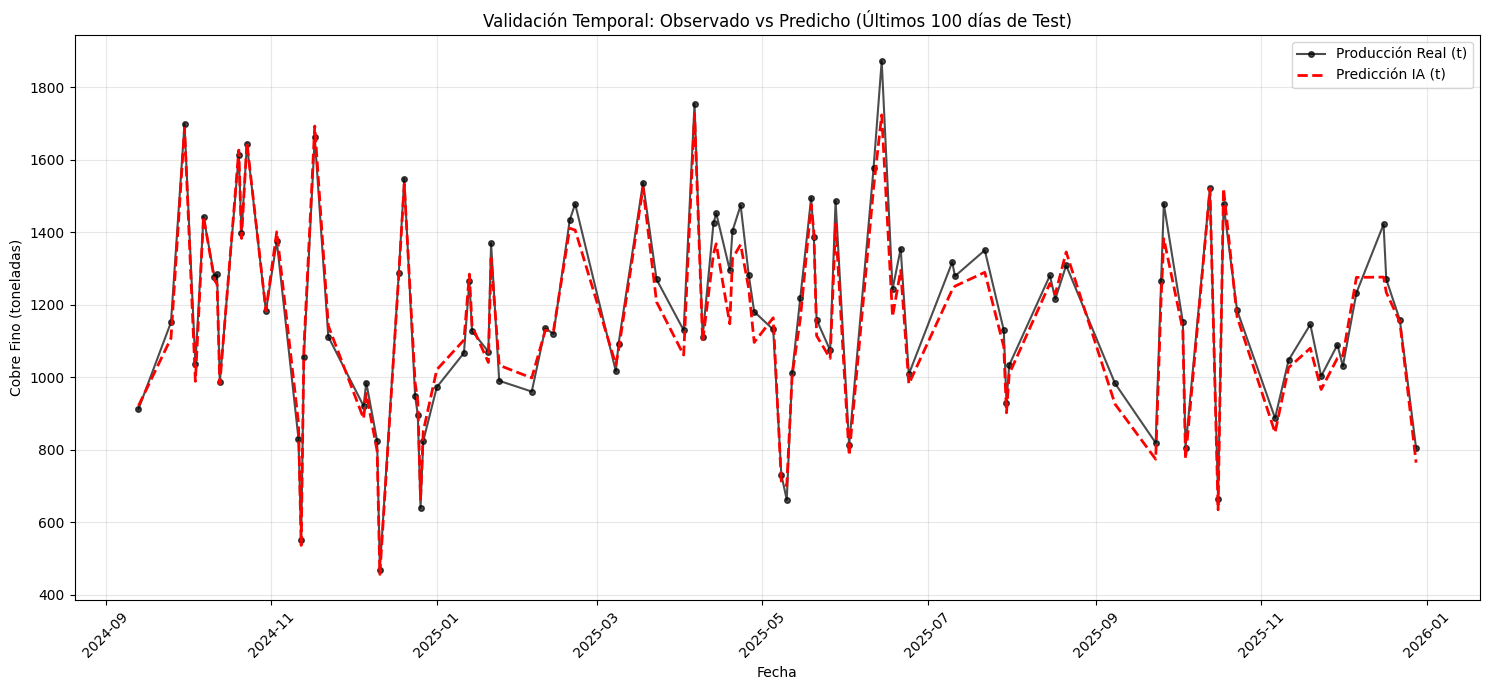

In [29]:
# comparacion de series temporales obs vs sim
import matplotlib.pyplot as plt

# 1. Preparar un DataFrame de validación con las fechas del set de prueba
df_validacion = df_limpio.loc[y_test.index].copy()
df_validacion['Real'] = y_test
df_validacion['Predicho'] = predicciones
df_validacion = df_validacion.sort_values(by='Fecha')

# 2. Graficar los últimos 100 días para ver el detalle
plt.figure(figsize=(15, 7))
plt.plot(df_validacion['Fecha'].tail(100), df_validacion['Real'].tail(100),
         label='Producción Real (t)', color='black', linewidth=1.5, marker='o', markersize=4, alpha=0.7)
plt.plot(df_validacion['Fecha'].tail(100), df_validacion['Predicho'].tail(100),
         label='Predicción IA (t)', color='red', linestyle='--', linewidth=2)

plt.title('Validación Temporal: Observado vs Predicho (Últimos 100 días de Test)')
plt.xlabel('Fecha')
plt.ylabel('Cobre Fino (toneladas)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

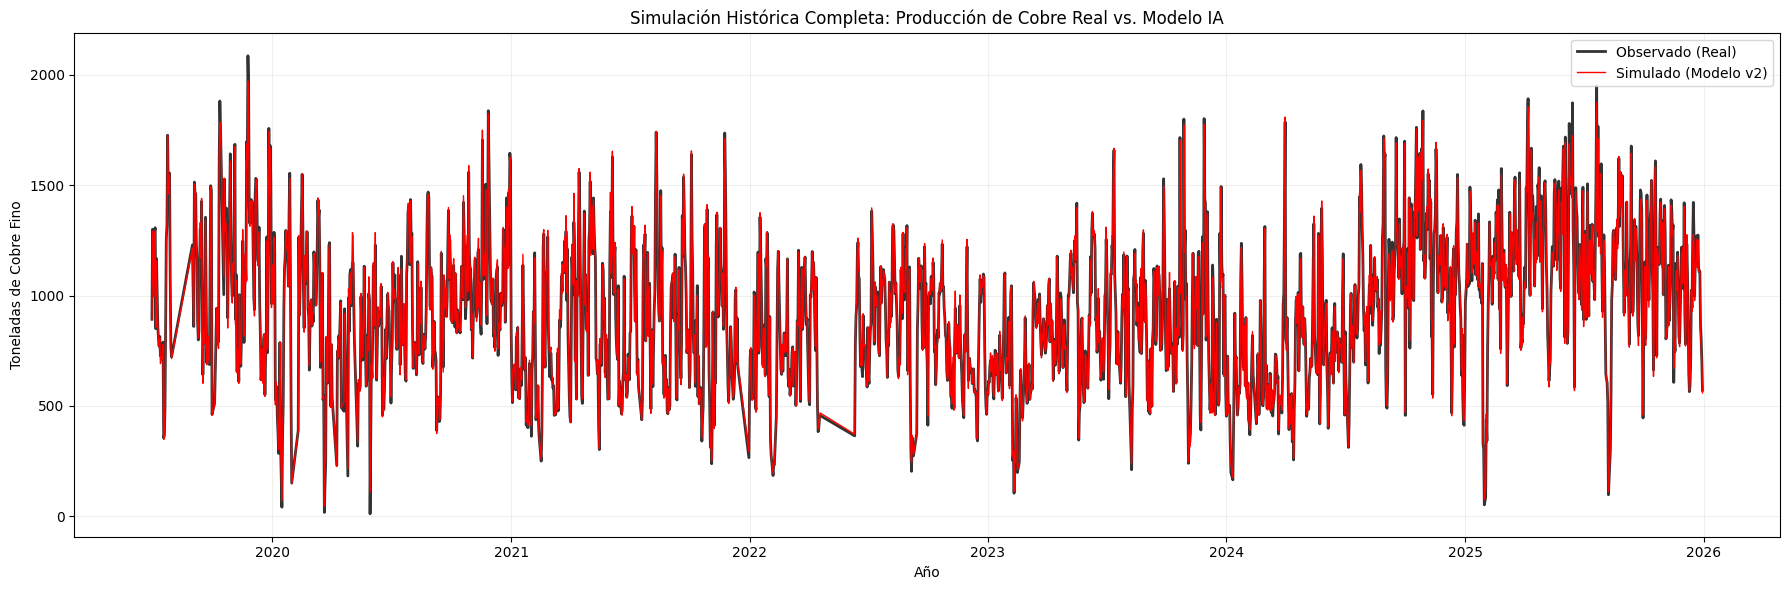

In [35]:
## grafico de serie total
import matplotlib.pyplot as plt

# 1. Generamos la predicción para todo el dataset (Simulación total)
df_limpio['Produccion_Simulada'] = modelo_v2.predict(df_limpio[features_actualizados])

# 2. Creamos el gráfico de serie temporal
plt.figure(figsize=(18, 6))

# Graficamos los datos reales (Observado)
plt.plot(df_limpio['Fecha'], df_limpio['Cu_Fino_Recuperado_t'],
         label='Observado (Real)', color='black', alpha=0.8, linewidth=2)

# Graficamos la simulación del modelo
plt.plot(df_limpio['Fecha'], df_limpio['Produccion_Simulada'],
         label='Simulado (Modelo v2)', color='red', alpha=1, linewidth=1)

plt.title('Simulación Histórica Completa: Producción de Cobre Real vs. Modelo IA')
plt.xlabel('Año')
plt.ylabel('Toneladas de Cobre Fino')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [36]:
## error acumulado  (sesgo)
error_total_ton = df_validacion['Real'].sum() - df_validacion['Predicho'].sum()
error_porcentual = (error_total_ton / df_validacion['Real'].sum()) * 100

print(f"Producción Real Acumulada: {df_validacion['Real'].sum():,.2f} t")
print(f"Producción IA Acumulada: {df_validacion['Predicho'].sum():,.2f} t")
print(f"Sesgo Total del Modelo: {error_porcentual:.2f}%")

Producción Real Acumulada: 420,052.25 t
Producción IA Acumulada: 419,911.02 t
Sesgo Total del Modelo: 0.03%


In [38]:
## aplicacion del modelo para predicciones
# preparando datos de entrada
import pandas as pd

# Datos de ejemplo para mañana (Planificación Mina/Planta)
data_mañana = {
    'Ley_Pct': [0.0105],                # 1.05% de Ley
    'Molido_Kt': [155.0],                # 155 Kt de molienda
    'Tox_Pct': [0.08],                   # 0.08% de Tóxicos
    'Disponibilidad_Molienda_Pct': [0.98] # 98% de disponibilidad
}

df_pred = pd.DataFrame(data_mañana)

# 2. Recrear las variables de ingeniería (Feature Engineering)
# Es vital calcular estas variables tal como lo hizo el modelo v2
df_pred['Ley_x_Tox'] = df_pred['Ley_Pct'] * df_pred['Tox_Pct']
df_pred['Sobre_Capacidad'] = (df_pred['Molido_Kt'] > 150).astype(int)

# Asegurar el orden correcto de las columnas según features_actualizados
columnas_modelo = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']
df_pred = df_pred[columnas_modelo]

## ejecucion de la prediccion
# Generar la predicción
prediccion_fino = modelo_v2.predict(df_pred)

print(f"--- RESULTADO DE SIMULACIÓN IA ---")
print(f"Producción estimada de Cu Fino: {prediccion_fino[0]:.2f} toneladas")




--- RESULTADO DE SIMULACIÓN IA ---
Producción estimada de Cu Fino: 1419.35 toneladas


In [39]:
## guardando modelo
import joblib

# Guardar modelo
joblib.dump(modelo_v2, 'modelo_produccion_cu_v2.pkl')

# Cargar modelo en otra sesión
# modelo_cargado = joblib.load('modelo_produccion_cu_v2.pkl')

['modelo_produccion_cu_v2.pkl']

In [40]:
## what if?
def simulador_what_if(ley, molido, tox, disponibilidad=0.98):
    # 1. Crear el escenario en un DataFrame
    escenario = pd.DataFrame({
        'Ley_Pct': [ley],
        'Molido_Kt': [molido],
        'Tox_Pct': [tox],
        'Disponibilidad_Molienda_Pct': [disponibilidad]
    })

    # 2. Aplicar la ingeniería de variables del Modelo v2
    escenario['Ley_x_Tox'] = escenario['Ley_Pct'] * escenario['Tox_Pct']
    escenario['Sobre_Capacidad'] = (escenario['Molido_Kt'] > 150).astype(int)

    # 3. Asegurar el orden de columnas para el modelo
    cols = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']

    # 4. Predecir
    prediccion = modelo_v2.predict(escenario[cols])[0]
    return prediccion

# --- EJEMPLO DE USO ---
# Escenario A: Mineral sucio (Tox 0.15)
prod_a = simulador_what_if(ley=0.011, molido=150, tox=0.15)

# Escenario B: Mineral limpio (Tox 0.06)
prod_b = simulador_what_if(ley=0.011, molido=150, tox=0.06)

print(f"Ganancia por limpieza de mineral: {prod_b - prod_a:.2f} toneladas de Cu fino/día")

Ganancia por limpieza de mineral: 1.36 toneladas de Cu fino/día


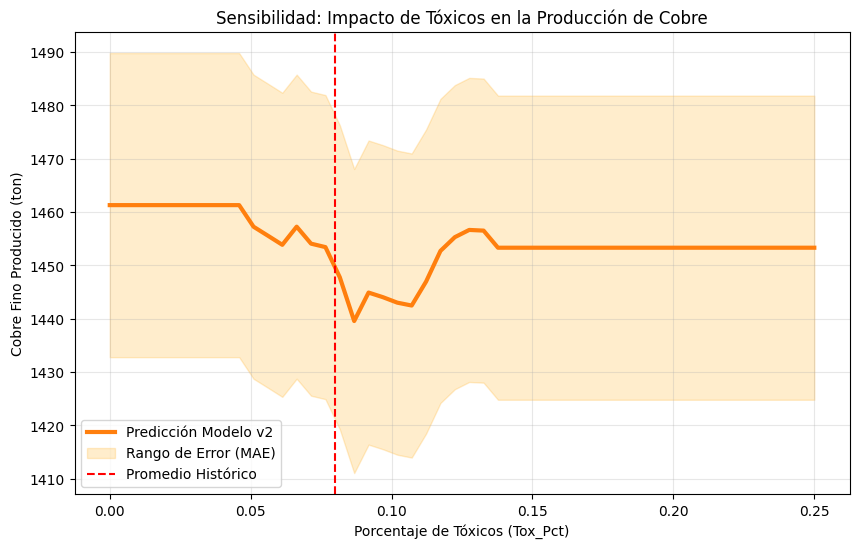

In [41]:
## curva de sensibilidad
import numpy as np
import matplotlib.pyplot as plt

# Definir rango de tóxicos (del 0% al 0.25%)
rango_tox = np.linspace(0, 0.25, 50)
ley_fija = 0.011  # 1.1%
molienda_fija = 150.0  # Capacidad nominal óptima detectada en EDA

# Simular resultados
resultados_sensibilidad = [simulador_what_if(ley_fija, molienda_fija, t) for t in rango_tox]

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(rango_tox, resultados_sensibilidad, color='tab:orange', linewidth=3, label='Predicción Modelo v2')
plt.fill_between(rango_tox,
                 np.array(resultados_sensibilidad) - 28.5,
                 np.array(resultados_sensibilidad) + 28.5,
                 color='orange', alpha=0.2, label='Rango de Error (MAE)')

plt.title('Sensibilidad: Impacto de Tóxicos en la Producción de Cobre')
plt.xlabel('Porcentaje de Tóxicos (Tox_Pct)')
plt.ylabel('Cobre Fino Producido (ton)')
plt.axvline(0.08, color='red', linestyle='--', label='Promedio Histórico') # Basado en tus histogramas
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Impacto Económico de la Variabilidad Química (Tóxicos): "A través del análisis de sensibilidad del Modelo IA v2, se ha cuantificado que el incremento de contaminantes desde el promedio histórico de 0.08% hasta un 0.12% de tóxicos genera una pérdida de recuperación neta de aproximadamente 7 toneladas de cobre fino por día. Bajo las condiciones actuales de mercado ($9,000 USD/t), esta ineficiencia química representa un costo de oportunidad de $1.89 millones de dólares mensuales. Dado que el modelo posee un error residual (MAE) de solo 28.5 t y una precisión del 98.5%, esta cifra constituye una base de decisión sólida para optimizar las estrategias de blending en mina y la dosificación de reactivos en planta."

In [44]:
## aplicacion al plan mensual
import pandas as pd
import joblib

# 1. Cargar el modelo entrenado y el plan
modelo = joblib.load('modelo_produccion_cu_v2.pkl')
plan_2026 = pd.read_csv('plan_enero_2026.csv')

# 2. Replicar el Feature Engineering (Crucial)
# Calculamos las variables que el modelo v2 aprendió a interpretar
plan_2026['Ley_x_Tox'] = plan_2026['Ley_Pct'] * plan_2026['Tox_Pct']
plan_2026['Sobre_Capacidad'] = (plan_2026['Molido_Kt'] > 150).astype(int)

# 3. Ejecutar la predicción
features = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']
plan_2026['Prediccion_Fino_t'] = modelo.predict(plan_2026[features])

# 4. Resultado mensual
total_enero = plan_2026['Prediccion_Fino_t'].sum()
print(f"Producción total proyectada para Enero 2026: {total_enero:,.2f} toneladas")


Producción total proyectada para Enero 2026: 42,784.16 toneladas


Fecha,Ley_Pct,Molido_Kt,Tox_Pct,Disponibilidad_Molienda_Pct
2026-01-01,0.011,148.5,0.08,0.98
2026-01-02,0.012,152.0,0.09,0.95
2026-01-03,0.010,0.0,0.00,0.00

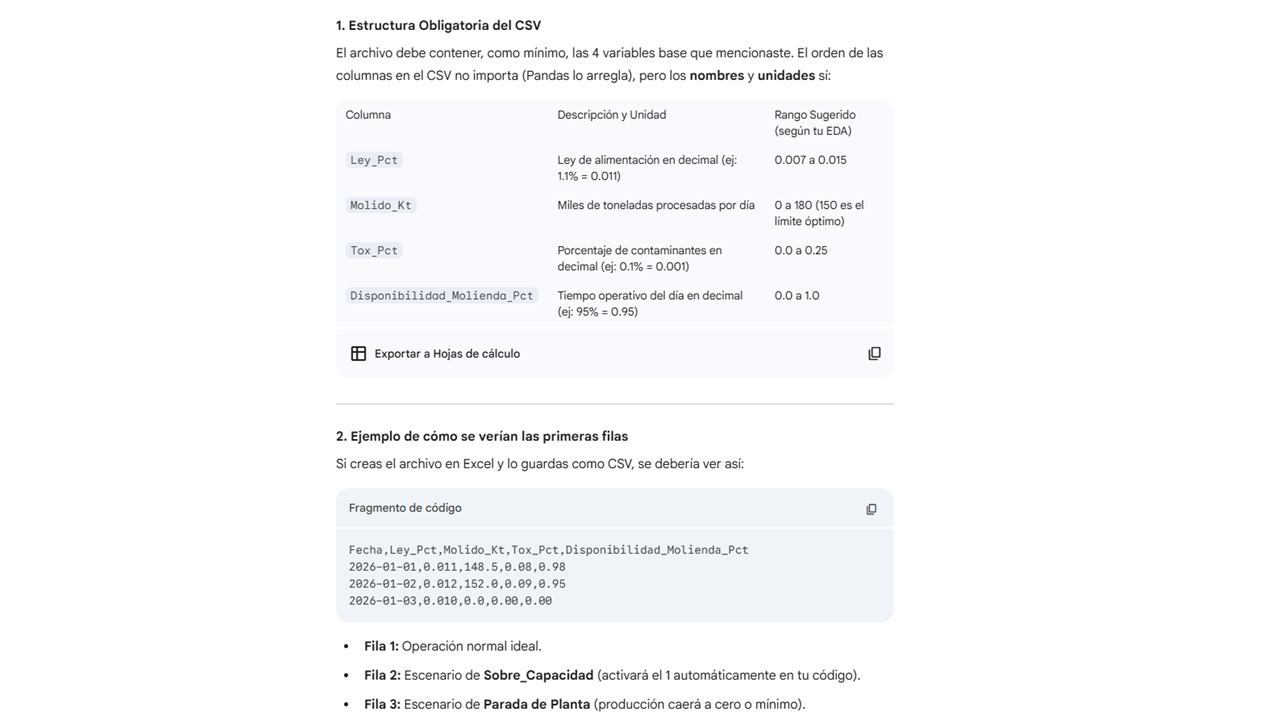

In [43]:
## ejemplo para inputs de plan mensual
import pandas as pd
import numpy as np

# Configurar fechas para enero 2026
fechas = pd.date_range(start='2026-01-01', end='2026-01-31')

# Crear datos sintéticos pero realistas basados en tu EDA
data = {
    'Fecha': fechas,
    'Ley_Pct': np.random.uniform(0.009, 0.013, len(fechas)), # Ley entre 0.9% y 1.3%
    'Molido_Kt': np.random.uniform(140, 160, len(fechas)),   # Mezcla de días normales y sobre-capacidad
    'Tox_Pct': np.random.uniform(0.05, 0.12, len(fechas)),   # Niveles de contaminantes variables
    'Disponibilidad_Molienda_Pct': np.random.uniform(0.92, 0.99, len(fechas)) # Alta disponibilidad
}

df_plan = pd.DataFrame(data)

# Simular una Parada de Planta el 15 de enero (Día de mantenimiento)
df_plan.loc[df_plan['Fecha'] == '2026-01-15', ['Molido_Kt', 'Disponibilidad_Molienda_Pct', 'Tox_Pct']] = 0

# Guardar como CSV
df_plan.to_csv('plan_enero_2026.csv', index=False)
print("Archivo 'plan_enero_2026.csv' creado con éxito.")

Archivo 'plan_enero_2026.csv' creado con éxito.


In [45]:
## aplicacion para plan mensual
import pandas as pd
import joblib
from google.colab import files
import io

# 1. Subir el archivo desde tu escritorio
print("Por favor, selecciona el archivo 'plan_enero_2026.csv' desde tu computadora:")
uploaded = files.upload()

# 2. Cargar el modelo (asegúrate de haber subido también el archivo .pkl a Colab)
# Puedes subir el .pkl usando la pestaña de archivos a la izquierda
modelo = joblib.load('modelo_produccion_cu_v2.pkl')

# 3. Leer el archivo cargado
nombre_archivo = list(uploaded.keys())[0]
plan_2026 = pd.read_csv(io.BytesIO(uploaded[nombre_archivo]))

# 4. Feature Engineering (Replicar la lógica del Modelo v2)
plan_2026['Ley_x_Tox'] = plan_2026['Ley_Pct'] * plan_2026['Tox_Pct']
plan_2026['Sobre_Capacidad'] = (plan_2026['Molido_Kt'] > 150).astype(int)

# 5. Ejecutar la predicción
features = ['Ley_Pct', 'Molido_Kt', 'Tox_Pct', 'Ley_x_Tox', 'Sobre_Capacidad', 'Disponibilidad_Molienda_Pct']
plan_2026['Prediccion_Fino_t'] = modelo.predict(plan_2026[features])

# 6. Mostrar resultados
total_enero = plan_2026['Prediccion_Fino_t'].sum()
print(f"\n--- RESULTADOS PARA {nombre_archivo} ---")
print(f"Producción Total Proyectada: {total_enero:,.2f} toneladas de Cu Fino")
display(plan_2026.head()) # Muestra las primeras filas con la predicción

Por favor, selecciona el archivo 'plan_enero_2026.csv' desde tu computadora:


Saving plan_enero_2026.csv to plan_enero_2026 (1).csv

--- RESULTADOS PARA plan_enero_2026 (1).csv ---
Producción Total Proyectada: 42,784.16 toneladas de Cu Fino


,Fecha,Ley_Pct,Molido_Kt,Tox_Pct,Disponibilidad_Molienda_Pct,Ley_x_Tox,Sobre_Capacidad,Prediccion_Fino_t
0,2026-01-01,0.009925,140.899818,0.097825,0.923430,0.000971,0,1258.713512
1,2026-01-02,0.009823,145.371603,0.087366,0.964883,0.000858,0,1232.753346
2,2026-01-03,0.009083,152.266384,0.088924,0.941880,0.000808,1,1179.576516
3,2026-01-04,0.012469,142.268767,0.091383,0.950332,0.001139,0,1524.171636
4,2026-01-05,0.009689,142.714152,0.060408,0.958969,0.000585,0,1221.006787


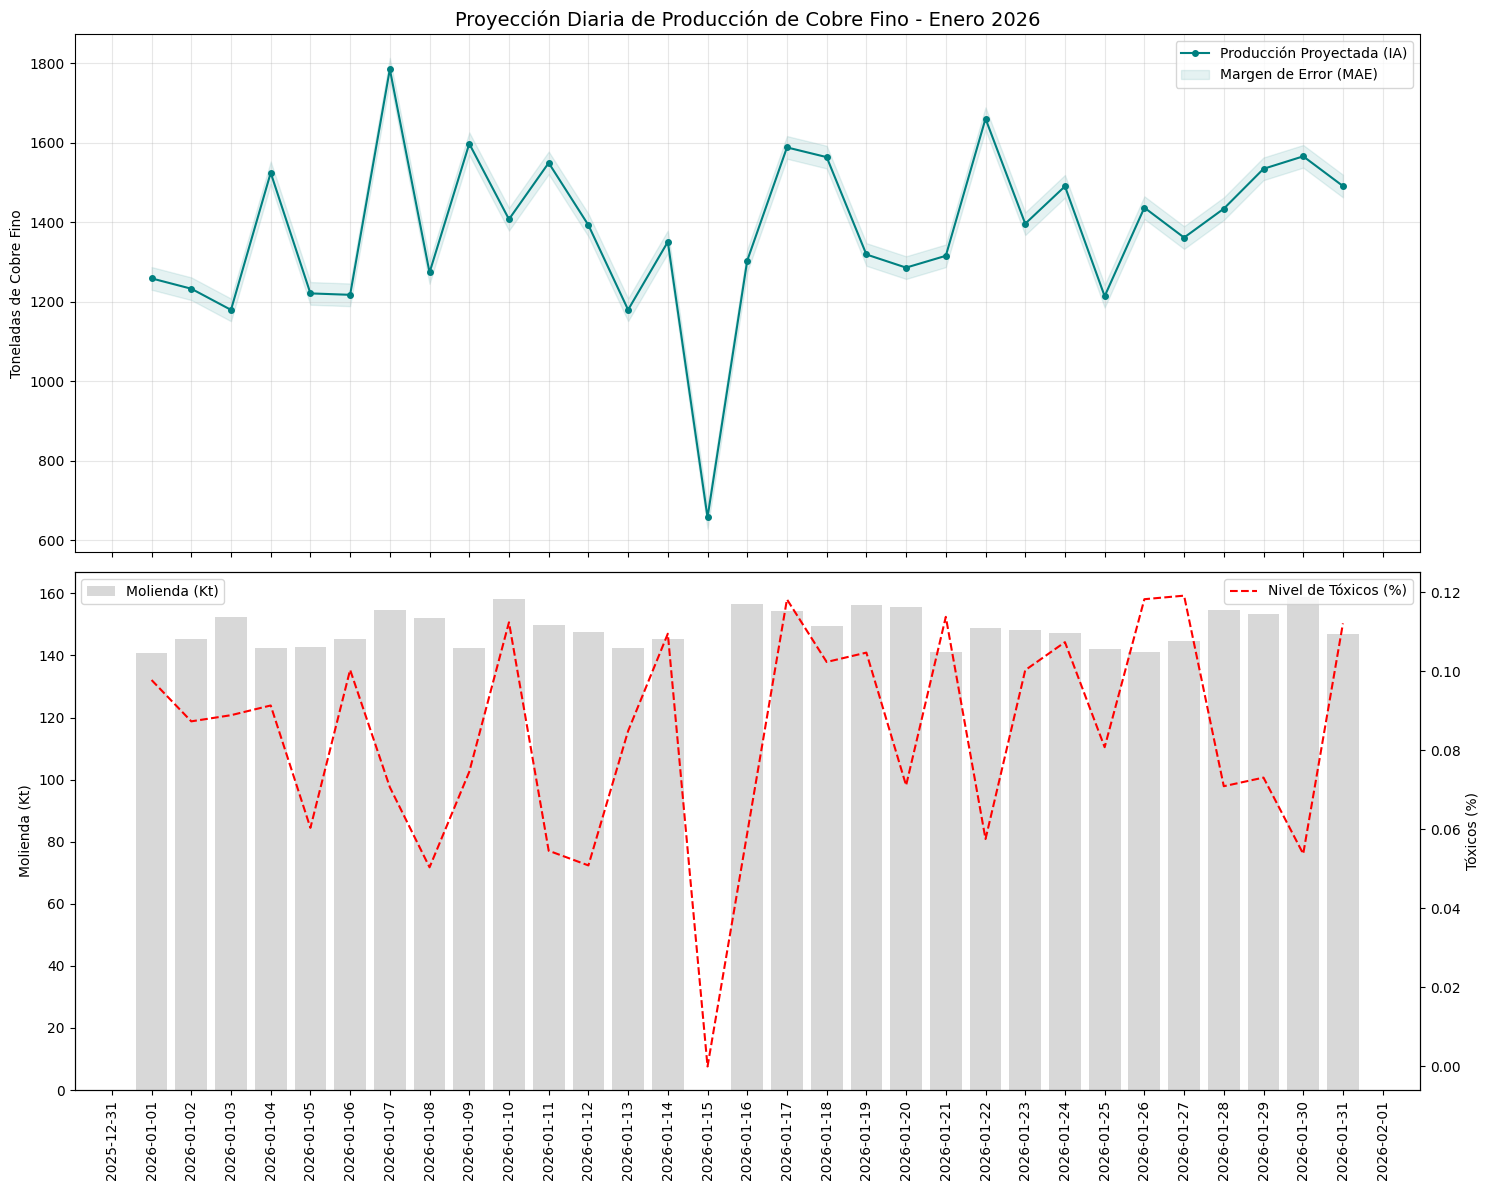

In [49]:
## aplicacion para plan mensual
# graficos
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Aseguramos que la columna 'Fecha' sea tipo datetime
plan_2026['Fecha'] = pd.to_datetime(plan_2026['Fecha'])

# 2. Crear la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# --- GRÁFICO 1: Serie Temporal de Producción ---
ax1.plot(plan_2026['Fecha'], plan_2026['Prediccion_Fino_t'],
         marker='o', markersize=4, color='teal', label='Producción Proyectada (IA)')
ax1.fill_between(plan_2026['Fecha'],
                 plan_2026['Prediccion_Fino_t'] - 28.5,
                 plan_2026['Prediccion_Fino_t'] + 28.5,
                 color='teal', alpha=0.1, label='Margen de Error (MAE)')

ax1.set_title('Proyección Diaria de Producción de Cobre Fino - Enero 2026', fontsize=14)
ax1.set_ylabel('Toneladas de Cobre Fino')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- GRÁFICO 2: Drivers (Molienda vs. Tóxicos) ---
ax2.bar(plan_2026['Fecha'], plan_2026['Molido_Kt'], color='gray', alpha=0.3, label='Molienda (Kt)')
ax2_twin = ax2.twinx()
ax2_twin.plot(plan_2026['Fecha'], plan_2026['Tox_Pct'], color='red', label='Nivel de Tóxicos (%)', linestyle='--')

ax2.set_ylabel('Molienda (Kt)')
ax2_twin.set_ylabel('Tóxicos (%)')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# --- FORZAR ROTACIÓN DE FECHAS A 90 GRADOS ---
# Usamos setp para forzar la rotación en las etiquetas del eje X
plt.setp(ax2.get_xticklabels(), rotation=90, horizontalalignment='center')

# Formatear para que muestre cada día de enero
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Formato completo Año-Mes-Día
ax2.xaxis.set_major_locator(mdates.DayLocator()) # Un tick por cada día

plt.tight_layout()
plt.show()

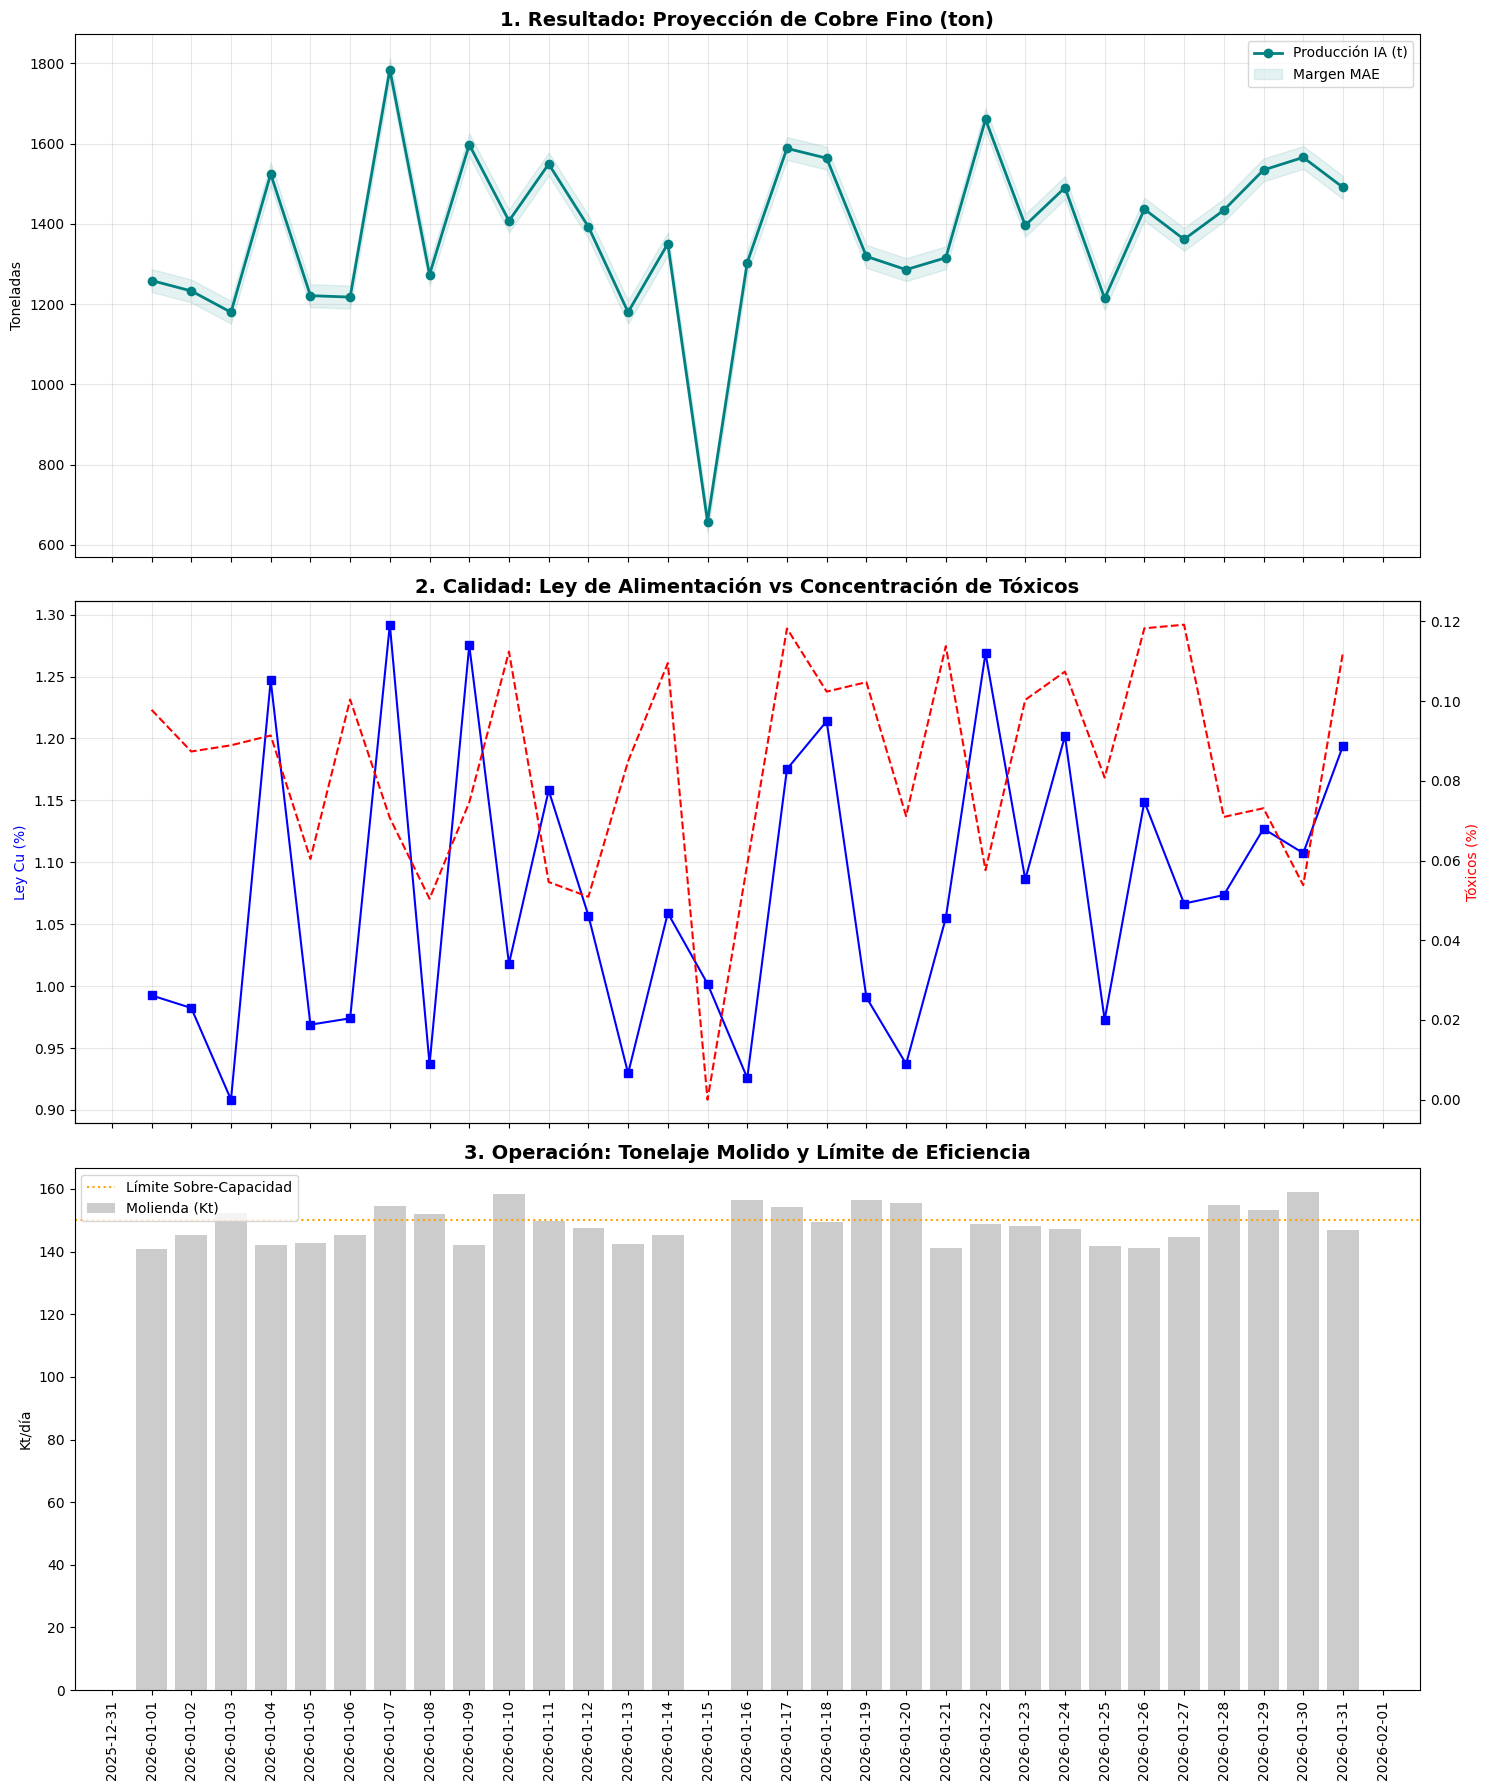

In [50]:
#proyeccion integral
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Asegurar formato datetime
plan_2026['Fecha'] = pd.to_datetime(plan_2026['Fecha'])

# 2. Crear panel de 3 gráficos
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# --- GRÁFICO 1: Producción Proyectada (Resultado) ---
ax1.plot(plan_2026['Fecha'], plan_2026['Prediccion_Fino_t'],
         marker='o', color='teal', linewidth=2, label='Producción IA (t)')
ax1.fill_between(plan_2026['Fecha'],
                 plan_2026['Prediccion_Fino_t'] - 28.5,
                 plan_2026['Prediccion_Fino_t'] + 28.5,
                 color='teal', alpha=0.1, label='Margen MAE')
ax1.set_title('1. Resultado: Proyección de Cobre Fino (ton)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Toneladas')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# --- GRÁFICO 2: Calidad del Mineral (Ley vs Tóxicos) ---
ax2.plot(plan_2026['Fecha'], plan_2026['Ley_Pct'] * 100, color='blue', marker='s', label='Ley de Cu (%)')
ax2_twin = ax2.twinx()
ax2_twin.plot(plan_2026['Fecha'], plan_2026['Tox_Pct'], color='red', linestyle='--', label='Tóxicos (%)')
ax2.set_title('2. Calidad: Ley de Alimentación vs Concentración de Tóxicos', fontsize=14, fontweight='bold')
ax2.set_ylabel('Ley Cu (%)', color='blue')
ax2_twin.set_ylabel('Tóxicos (%)', color='red')
ax2.grid(True, alpha=0.3)

# --- GRÁFICO 3: Intensidad Operativa (Molienda) ---
ax3.bar(plan_2026['Fecha'], plan_2026['Molido_Kt'], color='gray', alpha=0.4, label='Molienda (Kt)')
ax3.axhline(150, color='orange', linestyle=':', label='Límite Sobre-Capacidad')
ax3.set_title('3. Operación: Tonelaje Molido y Límite de Eficiencia', fontsize=14, fontweight='bold')
ax3.set_ylabel('Kt/día')
ax3.legend(loc='upper left')

# --- FORZAR ROTACIÓN 90° Y FORMATO DE FECHAS ---
plt.setp(ax3.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=10)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()

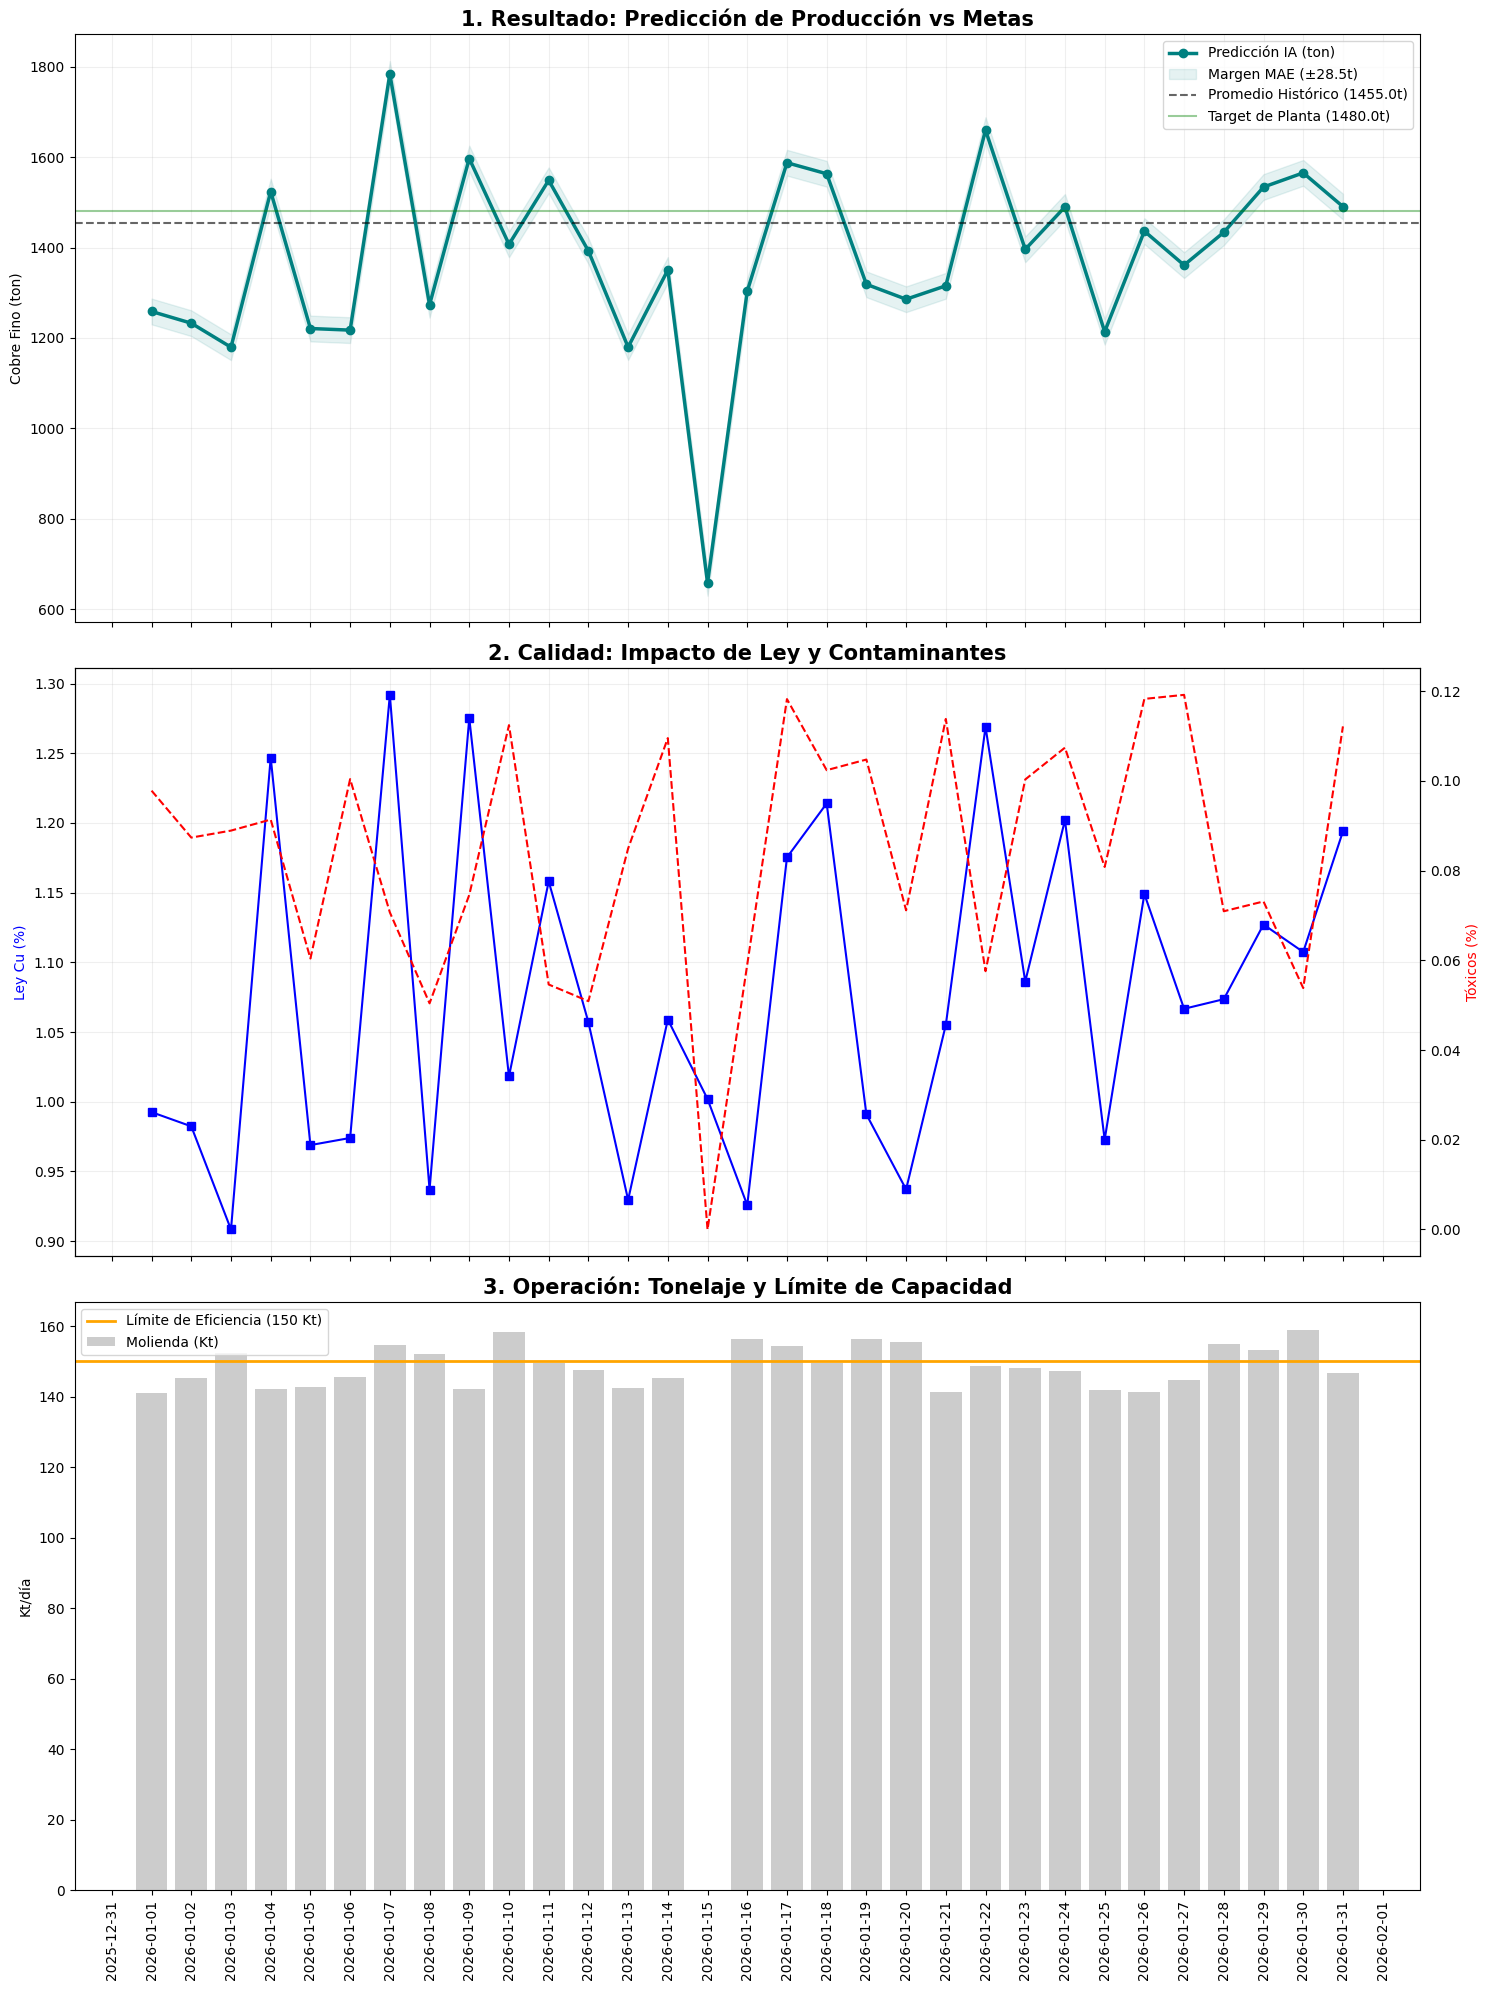

In [51]:
## proyeccion target para plan mensual
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Configurar metas (Basado en el promedio histórico del modelo)
prod_promedio_historica = 1455.0  # Valor central detectado en el modelo
target_operativo = 1480.0         # Meta de excelencia (superior al promedio)

# 2. Crear panel de 3 gráficos
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20), sharex=True)

# --- GRÁFICO 1: Resultado con Metas ---
ax1.plot(plan_2026['Fecha'], plan_2026['Prediccion_Fino_t'],
         marker='o', color='teal', linewidth=2.5, label='Predicción IA (ton)')
ax1.fill_between(plan_2026['Fecha'],
                 plan_2026['Prediccion_Fino_t'] - 28.5,
                 plan_2026['Prediccion_Fino_t'] + 28.5,
                 color='teal', alpha=0.1, label='Margen MAE (±28.5t)')

# Añadir líneas de referencia
ax1.axhline(prod_promedio_historica, color='black', linestyle='--', alpha=0.6, label=f'Promedio Histórico ({prod_promedio_historica}t)')
ax1.axhline(target_operativo, color='green', linestyle='-', alpha=0.4, label=f'Target de Planta ({target_operativo}t)')

ax1.set_title('1. Resultado: Predicción de Producción vs Metas', fontsize=15, fontweight='bold')
ax1.set_ylabel('Cobre Fino (ton)')
ax1.legend(loc='upper right', frameon=True)
ax1.grid(True, alpha=0.2)

# --- GRÁFICO 2: Calidad del Mineral (Ley vs Tóxicos) ---
ax2.plot(plan_2026['Fecha'], plan_2026['Ley_Pct'] * 100, color='blue', marker='s', label='Ley de Cu (%)')
ax2_twin = ax2.twinx()
ax2_twin.plot(plan_2026['Fecha'], plan_2026['Tox_Pct'], color='red', linestyle='--', label='Tóxicos (%)')
ax2.set_title('2. Calidad: Impacto de Ley y Contaminantes', fontsize=15, fontweight='bold')
ax2.set_ylabel('Ley Cu (%)', color='blue')
ax2_twin.set_ylabel('Tóxicos (%)', color='red')
ax2.grid(True, alpha=0.2)

# --- GRÁFICO 3: Intensidad Operativa (Molienda) ---
ax3.bar(plan_2026['Fecha'], plan_2026['Molido_Kt'], color='gray', alpha=0.4, label='Molienda (Kt)')
ax3.axhline(150, color='orange', linestyle='-', linewidth=2, label='Límite de Eficiencia (150 Kt)')
ax3.set_title('3. Operación: Tonelaje y Límite de Capacidad', fontsize=15, fontweight='bold')
ax3.set_ylabel('Kt/día')
ax3.legend(loc='upper left')

# --- ROTACIÓN DE FECHAS A 90 GRADOS (ASEGURADA) ---
plt.setp(ax3.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=10)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()

In [52]:
## cumplimiento y dias criticos
# 1. Calcular métricas de cumplimiento
dias_totales = len(plan_2026)
dias_cumplidos = len(plan_2026[plan_2026['Prediccion_Fino_t'] >= target_operativo])
pct_cumplimiento = (dias_cumplidos / dias_totales) * 100

# 2. Identificar los 3 días con mayor impacto negativo por Tóxicos
# (Días donde la Ley es buena pero la producción cae)
plan_2026['Impacto_Toxicos'] = plan_2026['Tox_Pct'] * plan_2026['Ley_Pct']
dias_criticos = plan_2026.sort_values(by='Tox_Pct', ascending=False).head(3)

print(f"--- RESUMEN EJECUTIVO: ENERO 2026 ---")
print(f"Cumplimiento del Target Operativo: {pct_cumplimiento:.1f}% ({dias_cumplidos} de {dias_totales} días)")
print(f"Producción Acumulada Proyectada: {plan_2026['Prediccion_Fino_t'].sum():,.2f} toneladas")
print(f"\n--- ALERTAS: DÍAS CON MAYOR CARGA DE TÓXICOS ---")
display(dias_criticos[['Fecha', 'Ley_Pct', 'Tox_Pct', 'Prediccion_Fino_t']])

--- RESUMEN EJECUTIVO: ENERO 2026 ---
Cumplimiento del Target Operativo: 35.5% (11 de 31 días)
Producción Acumulada Proyectada: 42,784.16 toneladas

--- ALERTAS: DÍAS CON MAYOR CARGA DE TÓXICOS ---


,Fecha,Ley_Pct,Tox_Pct,Prediccion_Fino_t
26,2026-01-27,0.010667,0.119183,1361.311638
25,2026-01-26,0.011490,0.118285,1436.504474
16,2026-01-17,0.011752,0.118238,1587.934088
